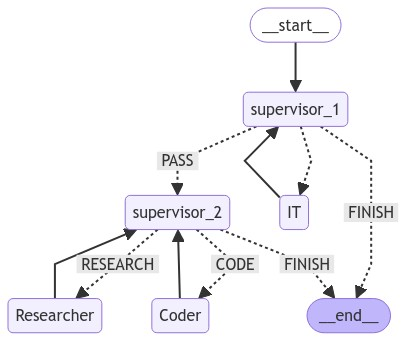

{'supervisor_1': {'next': 'IT'}}
----
{'IT': {'messages': [HumanMessage(content="There could be several reasons why you're unable to access www.google.com on your browser. Try the following troubleshooting steps:\n\n1. **Check Internet Connection**: Make sure you have a stable internet connection. Try to load other websites to confirm the internet is working fine.\n\n2. **Browser Updates**: Make sure your browser is up-to-date. Outdated browsers could have problems loading websites.\n\n3. **Clear Cache and Cookies**: Clearing your browser's cache and cookies can often solve many website loading errors.\n\n4. **Disable Extensions/Add-ons**: Some extensions or add-ons may interfere with how your browser loads certain websites. Try disabling them and see if the website loads.\n\n5. **Try Another Browser**: Try loading the website on a different browser to see if the issue is specific to one browser.\n\n6. **Check Firewall and Antivirus Settings**: Sometimes, your computer's firewall or an

In [1]:
import getpass
import os
import functools
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
from pydantic import BaseModel
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver


# Environment setup
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

os.environ["OPENAI_API_KEY"] = "my-key"

python_repl_tool = PythonREPLTool()

llm = ChatOpenAI(model="gpt-4")

@tool
def gpt_search(query: str) -> str:
    """
    検索ツール
    """
    ai_msg = llm.invoke(query)
    return ai_msg
    
@tool
def it_search(query: str) -> str:
    """Analyze IT problems"""
    ai_msg = llm.invoke(query)
    return ai_msg
    
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

members = ["IT", "Researcher", "Coder"]

# Define the supervisor prompts
system_prompt_1 = (
    "You are the first supervisor responsible for handling tasks related to IT related problems"
    " by asking the IT expert agent."
    " Given the user request, determine if it is a IT related problems and should be handled by you."
    " If yes, ask tools to analyse the problem and show the exact response from tool, then respond with FINISH."
    " If not, pass the request to the second supervisor."
)

system_prompt_2 = (
    "You are the second supervisor responsible for handling tasks related to research and coding."
    " Given the request from first supervisor, determine if it should be handled by you."
    " if yes, choose calling Researcher or Coder just once, and show the response, then respond with FINISH"
    " If not, respond with FINISH."
)

system_prompt_3 = (
    "You are the IT expert agent responsible for answering question from the first superviser."
)
    
# Define prompts
prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_1),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Should this request be handled by you or passed to the second supervisor? Select one of: {options}"),
    ]
).partial(options=["IT", "PASS", "FINISH"])

prompt_2 = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_2),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Should this request be handled by you or responded with FINISH? Select one of: {options}"),
    ]
).partial(options=["CODE", "RESEARCH", "FINISH"])

prompt_3 = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_3),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "If you think it is a network layer problem, just response with Network, and if you think it is application layer problem, response with Application. Otherwise, response with Others."),
    ]
)

# Define response models
class routeResponse(BaseModel):
    next: Literal["FINISH", "IT", "PASS"]

class routeResponse2(BaseModel):
    next: Literal["FINISH", "CODE", "RESEARCH"]

# Define supervisor agents
def supervisor_agent_1(state):
    supervisor_chain = (
        prompt_1
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

def supervisor_agent_2(state):
    supervisor_chain = (
        prompt_2
        | llm.with_structured_output(routeResponse2)
    )
    return supervisor_chain.invoke(state)

class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage], operator.add]
    next: str

research_agent = create_react_agent(llm, tools=[gpt_search])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

it_agent = create_react_agent(llm, tools=[it_search])
it_node = functools.partial(agent_node, agent=it_agent, name="IT")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor_1", supervisor_agent_1)
workflow.add_node("supervisor_2", supervisor_agent_2)
workflow.add_node("IT", it_node)

workflow.add_edge("IT", "supervisor_1")
workflow.add_edge("Researcher", "supervisor_2")
workflow.add_edge("Coder", "supervisor_2")

conditional_map_1 = {
    "IT": "IT",
    "PASS": "supervisor_2",
    "FINISH": END
}
workflow.add_conditional_edges("supervisor_1", lambda x: x["next"], conditional_map_1)

conditional_map_2 = {
    "RESEARCH": "Researcher",
    "CODE": "Coder",
    "FINISH": END
}
workflow.add_conditional_edges("supervisor_2", lambda x: x["next"], conditional_map_2)

workflow.add_edge(START, "supervisor_1")

memory = MemorySaver()

graph = workflow.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

thread = {"configurable": {"thread_id": "1"}}

if __name__ == '__main__':

    for s in graph.stream(
#        {"messages": [HumanMessage(content="what is the smallest country in the world")]},
#        {"messages": [HumanMessage(content="calculate 123 * 456 = ? and display the result")]},
        {"messages": [HumanMessage(content="I can not view www.google.com on my browser")]},
        thread,
#        {"recursion_limit": 100},
        
    ):
        if "__end__" not in s:
            print(s)
            print("----")
